In [343]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import qmc
import torch.nn as nn
import time
from pyDOE import lhs
from scipy.special import jv, hankel1
from functools import partial  # Higher-order functions and operations on callable objects
from pinns import derivative, MLP, init_weights
import warnings
#from scat_circ import u_exact_calc_for_pinns
from scat_circ import *
# Suppress warnings to keep the output clean
warnings.filterwarnings("ignore")

In [357]:
# Function to compute the exact solution
def sound_hard_circle_deepxde(k0, a, points):

  fem_xx = points[:, 0:1]
  fem_xy = points[:, 1:2]
  r = np.sqrt(fem_xx * fem_xx + fem_xy * fem_xy)
  theta = np.arctan2(fem_xy, fem_xx)
  npts = np.size(fem_xx, 0)
  n_terms = int(30 + (k0 * a)**1.01)
  u_sc = np.zeros((npts), dtype=np.complex128)
  for n in range(-n_terms, n_terms):
      bessel_deriv = jv(n-1, k0*a) - n/(k0*a) * jv(n, k0*a)
      hankel_deriv = n/(k0*a)*hankel1(n, k0*a) - hankel1(n+1, k0*a)
      u_sc += (-(1j)**(n) * (bessel_deriv/hankel_deriv) * hankel1(n, k0*r) * \
          np.exp(1j*n*theta)).ravel()
  return u_sc

# Flatten the grid for processing
points = np.column_stack((X.ravel(), Y.ravel()))

# Filter out points inside the circle
radii = np.sqrt(points[:, 0]**2 + points[:, 1]**2)
mask = radii > r_i
filtered_points = points[mask]

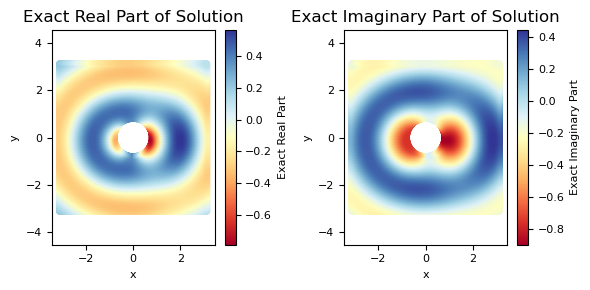

In [371]:
# Calculate the exact solution at the remaining points
exact_solution = sound_hard_circle_deepxde(k, r_i, filtered_points)

# Extract real and imaginary parts of the exact solution
real_exact = np.real(exact_solution)
imag_exact = np.imag(exact_solution)

# Create a figure for plotting
plt.figure(figsize=(6, 3))

# Scatter Plot for Exact Real Part
plt.subplot(1, 2, 1)
plt.scatter(filtered_points[:, 0], filtered_points[:, 1], c=real_exact, cmap='RdYlBu', s=10)
plt.colorbar(label='Exact Real Part')
plt.title('Exact Real Part of Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')

# Scatter Plot for Exact Imaginary Part
plt.subplot(1, 2, 2)
plt.scatter(filtered_points[:, 0], filtered_points[:, 1], c=imag_exact, cmap='RdYlBu', s=10)
plt.colorbar(label='Exact Imaginary Part')
plt.title('Exact Imaginary Part of Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')

plt.tight_layout()
plt.show()

In [359]:
def f(model, x_f, y_f, k):
    
    # Concatenate x_f and y_f to form the input domain
    domain = torch.stack((x_f, y_f), dim=1)
    
    # Pass the domain through the model to get the output
    u = model(domain)
    
    # Extract real and imaginary parts
    u_real = u[:, 0]
    u_imag = u[:, 1]
    
    # Calculate second-order derivatives
    u_real_xx = derivative(u_real, x_f, order=2)
    u_real_yy = derivative(u_real, y_f, order=2)
    u_imag_xx = derivative(u_imag, x_f, order=2)
    u_imag_yy = derivative(u_imag, y_f, order=2)
    
    # Calculate the Helmholtz equation components
    f_u_real = u_real_xx + u_real_yy + k**2 * u_real
    f_u_imag = u_imag_xx + u_imag_yy + k**2 * u_imag
    
    return f_u_real, f_u_imag

def mse_f(model, x_f, y_f, k):
    # Calcular f(x, y) a partir de la red neuronal
    f_u_real, f_u_imag = f(model, x_f, y_f, k)
    
    # Calcular el error cuadrático medio para las partes real e imaginaria
    error_f_real = torch.mean(f_u_real**2)
    error_f_imag = torch.mean(f_u_imag**2)
    
    # Sumar los errores para obtener el MSE total
    mse = error_f_real + error_f_imag
      
    return mse

In [ ]:
def mse_b(model, x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top,
          u_inner_t, u_left_t, u_right_t, u_bottom_t, u_top_t,k):

    #----------------------------------------------------
    # Inner
    # domain_inner = torch.stack((x_inner, y_inner), axis=1)
    # u_inner = model(domain_inner)
    # u_real_inner = u_inner[:, 0]
    # u_imag_inner = u_inner[:, 1]
    # u_inner_real_teo = torch.real(u_inner_t)
    # u_inner_imag_teo = torch.imag(u_inner_t)
    # error_real_inner = u_real_inner - u_inner_real_teo
    # error_imag_inner = u_imag_inner - u_inner_imag_teo
    # mse_inner = ((error_real_inner)**2 + (error_imag_inner)**2).mean()
    
    #----------------------------------------------------
    theta_inner = torch.atan2(y_inner, x_inner)
    domain_inner = torch.stack((x_inner, y_inner), axis=1)
    u_inner = model(domain_inner)
    u_real_inner = u_inner[:, 0]
    u_imag_inner = u_inner[:, 1]
    du_real_inner_dx = derivative(u_real_inner, x_inner, order=1)
    du_real_inner_dy = derivative(u_real_inner, y_inner, order=1)
    du_imag_inner_dx = derivative(u_imag_inner, x_inner, order=1)
    du_imag_inner_dy = derivative(u_imag_inner, y_inner, order=1)
    du_real_inner_dn = -(torch.cos(theta_inner) * du_real_inner_dx + torch.sin(theta_inner) * du_real_inner_dy)
    du_imag_inner_dn = -(torch.cos(theta_inner) * du_imag_inner_dx + torch.sin(theta_inner) * du_imag_inner_dy)
    ikx = 1j * k * x_inner
    exp_ikx = 1j*k*torch.exp(ikx) * (torch.cos(theta_inner))
    exp_ikx_real = torch.real(exp_ikx)  
    exp_ikx_imag = torch.imag(exp_ikx)
    error_real_inner =  du_real_inner_dn - exp_ikx_real
    error_imag_inner =  du_imag_inner_dn - exp_ikx_imag
    mse_inner = ((error_real_inner)**2 + (error_imag_inner)**2).mean()

    #----------------------------------------------------

    #----------------------------------------------------
    # Left Boundary
    # domain_left = torch.stack((x_left, y_left), axis=1)
    # u_left = model(domain_left)
    # u_real_left = u_left[:, 0]
    # u_imag_left = u_left[:, 1]
    # u_left_real_teo = torch.real(u_left_t)
    # u_left_imag_teo = torch.imag(u_left_t)
    # error_real_left = u_real_left - u_left_real_teo
    # error_imag_left = u_imag_left - u_left_imag_teo
    # mse_left = ((error_real_left)**2 + (error_imag_left)**2).mean()

    #----------------------------------------------------
    
    u_left = model(torch.stack((x_left, y_left), axis = 1))
    u_real_left = u_left[:, 0]
    u_imag_left = u_left[:, 1]
    du_real_dx_left = derivative(u_real_left, x_left, order=1)
    du_real_dy_left = derivative(u_real_left, y_left, order=1)
    du_imag_dx_left = derivative(u_imag_left, x_left, order=1)
    du_imag_dy_left = derivative(u_imag_left, y_left, order=1)
    du_real_dn_left = (-1) * du_real_dx_left  
    du_imag_dn_left = (-1) * du_imag_dx_left
    error_real_left = du_real_dn_left - (-k*u_imag_left)  
    error_imag_left = du_imag_dn_left - (k*u_real_left) 
    mse_left = ((error_real_left)**2 + (error_imag_left)**2).mean()
    #----------------------------------------------------

    #----------------------------------------------------
    # Right Boundary
    # domain_right = torch.stack((x_right, y_right), axis=1)
    # u_right = model(domain_right)
    # u_real_right = u_right[:, 0]
    # u_imag_right = u_right[:, 1]
    # u_right_real_teo = torch.real(u_right_t)
    # u_right_imag_teo = torch.imag(u_right_t)
    # error_real_right = u_real_right - u_right_real_teo
    # error_imag_right = u_imag_right - u_right_imag_teo
    # mse_right = ((error_real_right)**2 + (error_imag_right)**2).mean()
    #----------------------------------------------------

    u_right = model(torch.stack((x_right, y_right), axis=1))
    u_real_right = u_right[:, 0]
    u_imag_right = u_right[:, 1]
    du_real_dx_right = derivative(u_real_right, x_right, order=1)
    #du_real_dy_right = derivative(u_real_right, y_right, order=1)
    du_imag_dx_right = derivative(u_imag_right, x_right, order=1)
    #du_imag_dy_right = derivative(u_imag_right, y_right, order=1)
    du_real_dn_right = du_real_dx_right  
    du_imag_dn_right = du_imag_dx_right
    error_real_right = du_real_dn_right - (-k*u_imag_right)  
    error_imag_right = du_imag_dn_right - (k*u_real_right)
    mse_right = ((error_real_right)**2 + (error_imag_right)**2).mean()

    #----------------------------------------------------
    # Bottom Boundary
    # domain_bottom = torch.stack((x_bottom, y_bottom), axis=1)
    # u_bottom = model(domain_bottom)
    # u_real_bottom = u_bottom[:, 0]
    # u_imag_bottom = u_bottom[:, 1]
    # u_bottom_real_teo = torch.real(u_bottom_t)
    # u_bottom_imag_teo = torch.imag(u_bottom_t)
    # error_real_bottom = u_real_bottom - u_bottom_real_teo
    # error_imag_bottom = u_imag_bottom - u_bottom_imag_teo
    # mse_bottom = ((error_real_bottom)**2 + (error_imag_bottom)**2).mean()
    #----------------------------------------------------

    u_bottom = model(torch.stack((x_bottom, y_bottom), axis=1))
    u_real_bottom = u_bottom[:, 0]
    u_imag_bottom = u_bottom[:, 1]
    #du_real_dx_bottom = derivative(u_real_bottom, x_bottom, order=1)
    du_real_dy_bottom = derivative(u_real_bottom, y_bottom, order=1)
    #du_imag_dx_bottom = derivative(u_imag_bottom, x_bottom, order=1)
    du_imag_dy_bottom = derivative(u_imag_bottom, y_bottom, order=1)
    du_real_dn_bottom = (-1) * du_real_dy_bottom  
    du_imag_dn_bottom = (-1) * du_imag_dy_bottom
    error_real_bottom = du_real_dn_bottom - (-k*u_imag_bottom)  
    error_imag_bottom = du_imag_dn_bottom - (k*u_real_bottom)
    mse_bottom = ((error_real_bottom)**2 + (error_imag_bottom)**2).mean()

    #----------------------------------------------------
    # Top Boundary
#     domain_top = torch.stack((x_top, y_top), axis=1)
#     u_top = model(domain_top)
#     u_real_top = u_top[:, 0]
#     u_imag_top = u_top[:, 1]
#     u_top_real_teo = torch.real(u_top_t)
#     u_top_imag_teo = torch.imag(u_top_t)
#     error_real_top = u_real_top - u_top_real_teo
#     error_imag_top = u_imag_top - u_top_imag_teo
#     mse_top = ((error_real_top)**2 + (error_imag_top)**2).mean()
    #----------------------------------------------------
    u_top = model(torch.stack((x_top, y_top), axis=1))
    u_real_top = u_top[:, 0]
    u_imag_top = u_top[:, 1]
    #du_real_dx_top = derivative(u_real_top, x_top, order=1)
    du_real_dy_top = derivative(u_real_top, y_top, order=1)
    #du_imag_dx_top = derivative(u_imag_top, x_top, order=1)
    du_imag_dy_top = derivative(u_imag_top, y_top, order=1)
    du_real_dn_top = du_real_dy_top  
    du_imag_dn_top = du_imag_dy_top
    error_real_top = du_real_dn_top - (-k*u_imag_top)  
    error_imag_top = du_imag_dn_top - (k*u_real_top)
    mse_top = ((error_real_top)**2 + (error_imag_top)**2).mean()

    mse = (mse_inner + mse_left + mse_right + mse_bottom + mse_top)  

    return mse

In [394]:
def closure(model, optimizer, x_f, y_f, x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top,
          u_inner_t, u_left_t, u_right_t, u_bottom_t, u_top_t, k):
    
    # Reset gradients
    optimizer.zero_grad()
    
    # Calculate the loss
    loss_f = 1*mse_f(model, x_f, y_f, k)
    loss_b = 1*mse_b(model, x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top,
          u_inner_t, u_left_t, u_right_t, u_bottom_t, u_top_t, k)
    loss = loss_b + loss_f
    
    # Backpropagate the loss
    loss.backward(retain_graph=True)
    
    # Update iteration counter and print loss every 100 iterations
    global iter
    iter += 1
    if iter % 100 == 0:
        print(f"Iteration {iter}, Loss: {loss.item()}")
            
    return loss

In [395]:
# Function for L-BFGS training
def train_lbfgs(model, x_f, y_f, x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top,
          u_inner_t, u_left_t, u_right_t, u_bottom_t, u_top_t, k, num_iter=1_000):

    optimizer = torch.optim.LBFGS(model.parameters(),
                                    lr=1,
                                    max_iter=num_iter,
                                    max_eval=num_iter,
                                    tolerance_grad=1e-7,
                                    history_size=100,
                                    tolerance_change=1.0 * np.finfo(float).eps,
                                    line_search_fn="strong_wolfe")
 
    closure_fn = partial(closure, model, optimizer, x_f, y_f, x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top,
          u_inner_t, u_left_t, u_right_t, u_bottom_t, u_top_t, k)
    optimizer.step(closure_fn)

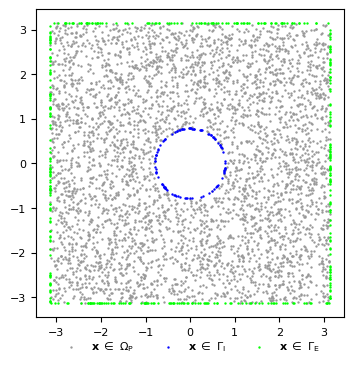

-


In [400]:
# Define the device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Parameters
nx = 100
n_Omega_P = 4000        # Number of points inside the annular region
n_Gamma_I = 100          # Number of points on the inner boundary (r = r_i)
n_Gamma_E = 200         # Number of points on the outer boundary (r = r_e)
r_i = np.pi / 4 # Inner radius
r_e = np.pi # Outer radius
k = 2.0  # Wave number
iter = 0  # Iteration counter
side_length = 2 * np.pi  # Side length of the square

# Generate random samples for points inside the square but outside the circle
points = []
while len(points) < n_Omega_P:
    x_samples = side_length * (np.random.rand(n_Omega_P) - 0.5)
    y_samples = side_length * (np.random.rand(n_Omega_P) - 0.5)
    mask = (x_samples**2 + y_samples**2) >= r_i**2
    points.extend(zip(x_samples[mask], y_samples[mask]))

# Trim the list to the desired number of points
points = points[:n_Omega_P]
x_samples, y_samples = zip(*points)

# Convert to numpy arrays
x_f = np.array(x_samples)
y_f = np.array(y_samples)

# Generate random points on the inner boundary (r = r_i)
theta_inner = 2 * np.pi * np.random.rand(n_Gamma_I)  # Uniform angular distribution
x_inner = r_i * np.cos(theta_inner)
y_inner = r_i * np.sin(theta_inner)

# Generate random points on the left, right, bottom, and top boundaries of the square
n_boundary_e = 100  # Number of points on each boundary
 
# Left boundary (excluding corners)
y_left = side_length * (np.random.rand(n_boundary_e) - 0.5)
x_left = -side_length / 2 * np.ones_like(y_left)

# Right boundary (excluding corners)
y_right = side_length * (np.random.rand(n_boundary_e) - 0.5)
x_right = side_length / 2 * np.ones_like(y_right)

# Bottom boundary (excluding corners)
x_bottom = side_length * (np.random.rand(n_boundary_e) - 0.5)
y_bottom = -side_length / 2 * np.ones_like(x_bottom)

# Top boundary (excluding corners)
x_top = side_length * (np.random.rand(n_boundary_e)- 0.5)
y_top = side_length / 2 * np.ones_like(x_top)

# Us teorics for inner boundary
R_inner = np.sqrt(x_inner**2 + y_inner**2)
Theta_inner = np.arctan2(y_inner, x_inner)
points_inner = np.column_stack((x_inner.ravel(), y_inner.ravel()))
#u_scn_inner, u_inner_ = u_exact_calc_for_pinns(R_inner, Theta_inner, r_i, k)
u_scn_inner = sound_hard_circle_deepxde(k, r_i, points_inner)
u_inner_t = torch.from_numpy(u_scn_inner).to(device)

# Us teorics for left boundary
R_left = np.sqrt(x_left**2 + y_left**2)
Theta_left = np.arctan2(y_left, x_left)
points_left = np.column_stack((x_left.ravel(), y_left.ravel()))
#u_scn_left, u_left_ = u_exact_calc_for_pinns(R_left, Theta_left, r_i, k)
u_scn_left = sound_hard_circle_deepxde(k, r_i, points_left)
u_left_t = torch.from_numpy(u_scn_left).to(device)

# Us teorics for right boundary
R_right = np.sqrt(x_right**2 + y_right**2)
Theta_right = np.arctan2(y_right, x_right)
points_right = np.column_stack((x_right.ravel(), y_right.ravel()))
#u_scn_right, u_right_ = u_exact_calc_for_pinns(R_right, Theta_right, r_i, k)
u_scn_right = sound_hard_circle_deepxde(k, r_i, points_right)
u_right_t = torch.from_numpy(u_scn_right).to(device)

# Us teorics for bottom boundary
R_bottom = np.sqrt(x_bottom**2 + y_bottom**2)
Theta_bottom = np.arctan2(y_bottom, x_bottom)
points_bottom = np.column_stack((x_bottom.ravel(), y_bottom.ravel()))
#u_scn_bottom, u_bottom_ = u_exact_calc_for_pinns(R_bottom, Theta_bottom, r_i, k)
u_scn_bottom = sound_hard_circle_deepxde(k, r_i, points_bottom)
u_bottom_t = torch.from_numpy(u_scn_bottom).to(device)

# Us teorics for top boundary
R_top = np.sqrt(x_top**2 + y_top**2)
Theta_top = np.arctan2(y_top, x_top)
points_top = np.column_stack((x_top.ravel(), y_top.ravel()))
#u_scn_top, u_top_ = u_exact_calc_for_pinns(R_top, Theta_top, r_i, k)
u_scn_top = sound_hard_circle_deepxde(k, r_i, points_top)
u_top_t = torch.from_numpy(u_scn_top).to(device)

# Convert to torch tensors
x_f = torch.from_numpy(x_f).float().to(device).requires_grad_(True)
y_f = torch.from_numpy(y_f).float().to(device).requires_grad_(True)
x_inner = torch.from_numpy(x_inner).float().to(device).requires_grad_(True)
y_inner = torch.from_numpy(y_inner).float().to(device).requires_grad_(True)
x_left = torch.from_numpy(x_left).float().to(device).requires_grad_(True)
y_left = torch.from_numpy(y_left).float().to(device).requires_grad_(True)
x_right = torch.from_numpy(x_right).float().to(device).requires_grad_(True)
y_right = torch.from_numpy(y_right).float().to(device).requires_grad_(True)
x_bottom = torch.from_numpy(x_bottom).float().to(device).requires_grad_(True)
y_bottom = torch.from_numpy(y_bottom).float().to(device).requires_grad_(True)
x_top = torch.from_numpy(x_top).float().to(device).requires_grad_(True)
y_top = torch.from_numpy(y_top).float().to(device).requires_grad_(True)


# Plot the points
plt.figure(figsize=(4, 4))
plt.scatter(x_f.cpu().detach().numpy(), y_f.cpu().detach().numpy(), c='#989898ff', s=2, marker='.', label=r"$\bf{x}$ $\in$ $\Omega_{\rm P}$")
plt.scatter(x_inner.cpu().detach().numpy(), y_inner.cpu().detach().numpy(), c='#0000ffff', s=2, marker='.', label=r"$\bf{x}$ $\in$ $\Gamma_{\rm I}$")
plt.scatter(x_left.cpu().detach().numpy(), y_left.cpu().detach().numpy(), c='#00ff00ff', s=2, marker='.', label=r"$\bf{x}$ $\in$ $\Gamma_{\rm E}$")
plt.scatter(x_right.cpu().detach().numpy(), y_right.cpu().detach().numpy(), c='#00ff00ff', s=2, marker='.')
plt.scatter(x_bottom.cpu().detach().numpy(), y_bottom.cpu().detach().numpy(), c='#00ff00ff', s=2, marker='.')
plt.scatter(x_top.cpu().detach().numpy(), y_top.cpu().detach().numpy(), c='#00ff00ff', s=2, marker='.')
#plt.xlim([-r_e, r_e])
#plt.ylim([-r_e, r_e])
plt.gca().set_aspect('equal', adjustable='box')

# Adjust the legend position and remove the box
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.04), frameon=False, ncol=3)

# Remove the ticks
#plt.axis('off')

# Show the plot
plt.show()

# Initialize the model with specified parameters and apply weights
model = MLP(input_size=2, output_size=2, hidden_layers=3, hidden_units=350, activation_function=nn.Tanh()).to(device)
# Initialize the weights
model.apply(init_weights)

print('-')

In [403]:
train_lbfgs(model,x_f,y_f,x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top,u_inner_t, u_left_t, u_right_t, u_bottom_t, u_top_t, k, num_iter = 10_000)

Iteration 1100, Loss: 0.016226472333073616
Iteration 1200, Loss: 0.01035018265247345
Iteration 1300, Loss: 0.006472098641097546
Iteration 1400, Loss: 0.004509551450610161
Iteration 1500, Loss: 0.003490488277748227
Iteration 1600, Loss: 0.0027318759821355343
Iteration 1700, Loss: 0.0022423015907406807
Iteration 1800, Loss: 0.0018623392097651958
Iteration 1900, Loss: 0.0015405857702717185
Iteration 2000, Loss: 0.0012963352492079139
Iteration 2100, Loss: 0.0011135134845972061
Iteration 2200, Loss: 0.0009546793880872428
Iteration 2300, Loss: 0.0008217284339480102
Iteration 2400, Loss: 0.0007079655188135803
Iteration 2500, Loss: 0.000610753137152642
Iteration 2600, Loss: 0.0005318798939697444
Iteration 2700, Loss: 0.000479349575471133
Iteration 2800, Loss: 0.0004276769468560815
Iteration 2900, Loss: 0.00038557156221941113
Iteration 3000, Loss: 0.0003436330007389188
Iteration 3100, Loss: 0.0003073117695748806
Iteration 3200, Loss: 0.00027894077356904745
Iteration 3300, Loss: 0.00025531888240

Maximum value of predicted real part: 0.5845859
Minimum value of predicted real part: -0.7794115


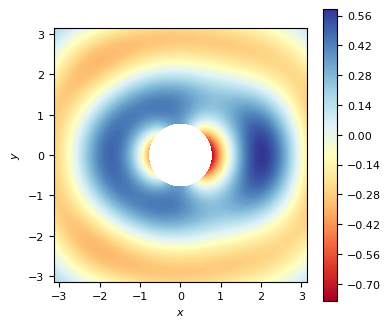

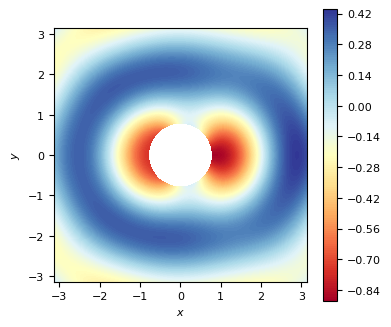

In [404]:
# Número de muestras en x y y
dom_samples = 500
x = np.linspace(-np.pi, np.pi, dom_samples)
y = np.linspace(-np.pi, np.pi, dom_samples)

# Malla del dominio
X, Y = np.meshgrid(x, y)

R_exact = np.sqrt(X**2 + Y**2) 
u_amp_exact = np.real( np.exp(-1j * X * k))

# Convertir los datos X e Y a tensores de PyTorch y cambiar su forma
X_ten = torch.tensor(X).float().reshape(-1, 1).to(device)
Y_ten = torch.tensor(Y).float().reshape(-1, 1).to(device)

# Concatenar los tensores X e Y en un solo tensor
domain_ten = torch.cat([X_ten,Y_ten], dim = 1) 
U_pred = model(domain_ten)
U_real = U_pred[:, 0].detach().cpu().numpy().reshape(X.shape)
U_imag = U_pred[:, 1].detach().cpu().numpy().reshape(X.shape)

u_amp_exact = np.ma.masked_where(R_exact < r_i, u_amp_exact)
u_amp_exact = np.ma.masked_where(R_exact > r_e, u_amp_exact)
U_real = np.ma.masked_where(R_exact < r_i, U_real)
U_imag = np.ma.masked_where(R_exact < r_i, U_imag)

#U_real = np.ma.masked_where(R_exact > r_e, U_real)

plt.figure(figsize=(4, 4))


plt.contourf(X, Y, U_real, cmap='RdYlBu', levels=150)
plt.colorbar(shrink=0.8)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.axis("image")
plt.grid(False)
#plt.axis("off")
plt.gca().set_aspect("equal")
plt.tight_layout()

plt.figure(figsize=(4, 4))


plt.contourf(X, Y, U_imag, cmap='RdYlBu', levels=150)
plt.colorbar(shrink=0.8)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.axis("image")
plt.grid(False)
#plt.axis("off")
plt.gca().set_aspect("equal")
plt.tight_layout()

# Print the maximum and minimum values of the predicted real and imaginary parts
print("Maximum value of predicted real part:", np.nanmax(U_real))
print("Minimum value of predicted real part:", np.nanmin(U_real))